In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/econ_515/model

/content/gdrive/MyDrive/econ_515/model


In [ ]:
!pip install --upgrade xlrd
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls

causal_convolution_layer.py  lstm_gas.pt  __pycache__  tsf.pt


In [2]:
import numpy as np
import pandas as pd
import xlrd
from torchinfo import summary
import argparse
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision import transforms
import numpy as np
from datetime import date
import datetime
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import psycopg2

In [3]:
## read_excel
Natural_Gas = pd.read_excel('../data/gas_price.xls', sheet_name='Data 1', header=2, index_col=0)
Crude_Oil = pd.read_excel('../data/price_for_variables.xls', sheet_name='Data 1', header=2, index_col=0)
Heating_Oil = pd.read_excel('../data/price_for_variables.xls', sheet_name='Data 4', header=2, index_col=0)
Drilling = pd.read_excel('../data/drilling.xls', sheet_name='Data 3', header=2, index_col=0)

Production = pd.read_excel('../data/data.xls', sheet_name='Data 2', header=2, index_col=0)
Imports_Exports = pd.read_excel('../data/data.xls', sheet_name='Data 3', header=2, index_col=0)
Underground_Storage = pd.read_excel('../data/data.xls', sheet_name='Data 4', header=2, index_col=0)
Consumption = pd.read_excel('../data/data.xls', sheet_name='Data 5', header=2, index_col=0)


In [4]:
## get variables
start_date = '2001-01-15'
end_date = '2022-07-15'
Natural_Gas_Price = Natural_Gas.loc[start_date: end_date, 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)']
Crude_Oil_Price = Crude_Oil.loc[start_date: end_date, 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']
Heating_Oil_Price = Heating_Oil.loc[start_date: end_date, 'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)']
Drilling_activity = Drilling.loc[start_date: end_date, 'U.S. Natural Gas Rotary Rigs in Operation (Count)']

Natural_Gas_Supply = Production.loc[start_date: end_date, 'U.S. Natural Gas Marketed Production (MMcf)']
Natural_Gas_Demand = Consumption.loc[start_date: end_date, 'U.S. Natural Gas Industrial Consumption (MMcf)']
Natural_Gas_Storage = Underground_Storage.loc[start_date: end_date, 'U.S. Natural Gas Underground Storage Volume (MMcf)']
Natural_Gas_Import = Imports_Exports.loc[start_date: end_date, 'U.S. Natural Gas Imports (MMcf)']
Natural_Gas_Export = Imports_Exports.loc[start_date: end_date, 'U.S. Natural Gas Exports (MMcf)']


df = pd.concat([Natural_Gas_Price, Crude_Oil_Price, Heating_Oil_Price, Drilling_activity, Natural_Gas_Supply, Natural_Gas_Demand, Natural_Gas_Storage, Natural_Gas_Import, Natural_Gas_Export], axis=1)
df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)':'Natural_Gas_Price',
                          'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'Crude_Oil_Price',
                          'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)':'Heating_Oil_Price',
                          'U.S. Natural Gas Rotary Rigs in Operation (Count)':'Drilling_activity',
                          'U.S. Natural Gas Marketed Production (MMcf)':'Natural_Gas_Supply',
                          'U.S. Natural Gas Industrial Consumption (MMcf)':'Natural_Gas_Demand',
                          'U.S. Natural Gas Underground Storage Volume (MMcf)':'Natural_Gas_Storage',
                          'U.S. Natural Gas Imports (MMcf)':'Natural_Gas_Import',
                          'U.S. Natural Gas Exports (MMcf)':'Natural_Gas_Export'},inplace=True)
df

,Natural_Gas_Price,Crude_Oil_Price,Heating_Oil_Price,Drilling_activity,Natural_Gas_Supply,Natural_Gas_Demand,Natural_Gas_Storage,Natural_Gas_Import,Natural_Gas_Export
Date,,,,,,,,,
2001-01-15,8.17,29.59,0.845,879.0,1753237,686540.0,5609446.0,373077,25547
2001-02-15,5.61,29.61,0.785,898.0,1582557,640026.0,5240820.0,328289,26882
2001-03-15,5.23,27.25,0.741,913.0,1766754,664918.0,5041971.0,358103,32121
2001-04-15,5.19,27.49,0.782,957.0,1703310,622054.0,5252851.0,318573,23637
2001-05-15,4.19,28.63,0.772,997.0,1763141,576532.0,5749464.0,321878,28981
...,...,...,...,...,...,...,...,...,...
2022-03-15,4.90,108.50,3.635,135.0,3225163,753815.0,5835467.0,260642,637564
2022-04-15,6.60,101.78,3.952,142.0,3151649,701654.0,6051522.0,246576,586271
2022-05-15,8.14,109.55,4.497,149.0,3295871,680841.0,6443525.0,232669,614309


In [5]:
features = df.columns
for feature in features:
    df[feature+'_dif1'] = df[feature] - df[feature].shift(periods=1)
    df[feature+'_dif1_3m'] = df[feature+'_dif1'].rolling(3).mean()
    df[feature+'_dif1_6m'] = df[feature+'_dif1'].rolling(6).mean()
    df[feature+'_3m']=df[feature].rolling(3).mean()
    df[feature+'_6m']=df[feature].rolling(6).mean()
df['label'] = df['Natural_Gas_Price'].shift(periods=-1)
df

,Natural_Gas_Price,Crude_Oil_Price,Heating_Oil_Price,Drilling_activity,Natural_Gas_Supply,Natural_Gas_Demand,Natural_Gas_Storage,Natural_Gas_Import,Natural_Gas_Export,Natural_Gas_Price_dif1,...,Natural_Gas_Import_dif1_3m,Natural_Gas_Import_dif1_6m,Natural_Gas_Import_3m,Natural_Gas_Import_6m,Natural_Gas_Export_dif1,Natural_Gas_Export_dif1_3m,Natural_Gas_Export_dif1_6m,Natural_Gas_Export_3m,Natural_Gas_Export_6m,label
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-15,8.17,29.59,0.845,879.0,1753237,686540.0,5609446.0,373077,25547,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.61
2001-02-15,5.61,29.61,0.785,898.0,1582557,640026.0,5240820.0,328289,26882,-2.56,...,NaN,NaN,NaN,NaN,1335.0,NaN,NaN,NaN,NaN,5.23
2001-03-15,5.23,27.25,0.741,913.0,1766754,664918.0,5041971.0,358103,32121,-0.38,...,NaN,NaN,353156.333333,NaN,5239.0,NaN,NaN,28183.333333,NaN,5.19
2001-04-15,5.19,27.49,0.782,957.0,1703310,622054.0,5252851.0,318573,23637,-0.04,...,-18168.000000,NaN,334988.333333,NaN,-8484.0,-636.666667,NaN,27546.666667,NaN,4.19
2001-05-15,4.19,28.63,0.772,997.0,1763141,576532.0,5749464.0,321878,28981,-1.00,...,-2137.000000,NaN,332851.333333,NaN,5344.0,699.666667,NaN,28246.333333,NaN,3.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15,4.90,108.50,3.635,135.0,3225163,753815.0,5835467.0,260642,637564,0.21,...,2672.000000,6739.333333,272070.000000,256574.000000,92001.0,5559.333333,16996.833333,597743.000000,586025.333333,6.60
2022-04-15,6.60,101.78,3.952,142.0,3151649,701654.0,6051522.0,246576,586271,1.70,...,-16534.333333,3062.166667,255535.666667,259636.166667,-51293.0,-7943.666667,6869.333333,589799.333333,592894.666667,8.14
2022-05-15,8.14,109.55,4.497,149.0,3295871,680841.0,6443525.0,232669,614309,1.54,...,-8906.666667,-1622.666667,246629.000000,258013.500000,28038.0,22915.333333,9554.500000,612714.666667,602449.166667,7.70


In [6]:
df = df.dropna()
all_features = df.columns.drop('label')
df

,Natural_Gas_Price,Crude_Oil_Price,Heating_Oil_Price,Drilling_activity,Natural_Gas_Supply,Natural_Gas_Demand,Natural_Gas_Storage,Natural_Gas_Import,Natural_Gas_Export,Natural_Gas_Price_dif1,...,Natural_Gas_Import_dif1_3m,Natural_Gas_Import_dif1_6m,Natural_Gas_Import_3m,Natural_Gas_Import_6m,Natural_Gas_Export_dif1,Natural_Gas_Export_dif1_3m,Natural_Gas_Export_dif1_6m,Natural_Gas_Export_3m,Natural_Gas_Export_6m,label
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-15,3.11,26.43,0.698,1058.0,1737185,570067.0,6576075.0,364571,31219,-0.61,...,15332.666667,-1417.666667,334621.000000,334804.666667,6665.0,2527.333333,945.333333,28251.333333,27899.000000,2.97
2001-08-15,2.97,27.37,0.734,1032.0,1737283,589875.0,6888848.0,353338,28965,-0.14,...,10486.666667,4174.833333,345107.666667,338979.500000,-2254.0,-5.333333,347.166667,28246.000000,28246.166667,2.19
2001-09-15,2.19,26.20,0.731,972.0,1688682,578590.0,7261934.0,314864,33517,-0.78,...,-850.000000,-7206.500000,344257.666667,331773.000000,4552.0,2987.666667,232.666667,31233.666667,28478.833333,2.46
2001-10-15,2.46,22.17,0.628,913.0,1757397,617291.0,7453778.0,326114,34452,0.27,...,-12819.000000,1256.833333,331438.666667,333029.833333,935.0,1077.666667,1802.500000,32311.333333,30281.333333,2.34
2001-11-15,2.34,19.64,0.548,825.0,1671377,618950.0,7554750.0,291044,41840,-0.12,...,-20764.666667,-5139.000000,310674.000000,327890.833333,7388.0,4291.666667,2143.166667,36603.000000,32424.500000,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,4.69,91.64,2.737,121.0,2870165,722916.0,5996508.0,259389,545563,0.31,...,5661.333333,6405.000000,269398.000000,249834.666667,-64539.0,-3806.333333,-3001.500000,592183.666667,569028.500000,4.90
2022-03-15,4.90,108.50,3.635,135.0,3225163,753815.0,5835467.0,260642,637564,0.21,...,2672.000000,6739.333333,272070.000000,256574.000000,92001.0,5559.333333,16996.833333,597743.000000,586025.333333,6.60
2022-04-15,6.60,101.78,3.952,142.0,3151649,701654.0,6051522.0,246576,586271,1.70,...,-16534.333333,3062.166667,255535.666667,259636.166667,-51293.0,-7943.666667,6869.333333,589799.333333,592894.666667,8.14


In [7]:
all_features

Index(['Natural_Gas_Price', 'Crude_Oil_Price', 'Heating_Oil_Price',
       'Drilling_activity', 'Natural_Gas_Supply', 'Natural_Gas_Demand',
       'Natural_Gas_Storage', 'Natural_Gas_Import', 'Natural_Gas_Export',
       'Natural_Gas_Price_dif1', 'Natural_Gas_Price_dif1_3m',
       'Natural_Gas_Price_dif1_6m', 'Natural_Gas_Price_3m',
       'Natural_Gas_Price_6m', 'Crude_Oil_Price_dif1',
       'Crude_Oil_Price_dif1_3m', 'Crude_Oil_Price_dif1_6m',
       'Crude_Oil_Price_3m', 'Crude_Oil_Price_6m', 'Heating_Oil_Price_dif1',
       'Heating_Oil_Price_dif1_3m', 'Heating_Oil_Price_dif1_6m',
       'Heating_Oil_Price_3m', 'Heating_Oil_Price_6m',
       'Drilling_activity_dif1', 'Drilling_activity_dif1_3m',
       'Drilling_activity_dif1_6m', 'Drilling_activity_3m',
       'Drilling_activity_6m', 'Natural_Gas_Supply_dif1',
       'Natural_Gas_Supply_dif1_3m', 'Natural_Gas_Supply_dif1_6m',
       'Natural_Gas_Supply_3m', 'Natural_Gas_Supply_6m',
       'Natural_Gas_Demand_dif1', 'Natural_Gas_

In [20]:
import lightgbm as lgb
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(df[all_features], df['label'], test_size=0.2, shuffle=False)

lgb_train = lgb.Dataset(X_train,Y_train)
lgb_eval = lgb.Dataset(X_test,Y_test,reference=lgb_train)

params = {'task':'train',
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','mse'},
    'num_leaves':31,
    'learning_rate':0.05,
    'feature_fraction':0.9,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbose':0}


#使用选择的参数进行训练
gbm = lgb.train(params,lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    early_stopping_rounds=5, 
    verbose_eval=False)  
#verbose_eval=False这个参数是控制每次训练不输出迭代效果参数

#下面进行预测
lgb_predict = gbm.predict(X_test,num_iteration=gbm.best_iteration) 
#输出均方根误差
# print(mean_squared_error(Y_test,lgb_predit) ** 0.5)     

### 保存模型特征重要性，方便后面特征选择
importance_df = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
importance_df['importance']=list(gbm.feature_importance())                
# 特征分数
importance_df = importance_df.sort_values(by='importance',ascending=False)  
importance_df                    

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/anaconda3/envs/cryptoquant/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/cryptoquant/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


,feature,importance
0,Natural_Gas_Price,76
12,Natural_Gas_Price_3m,29
11,Natural_Gas_Price_dif1_6m,26
48,Natural_Gas_Import_6m,21
49,Natural_Gas_Export_dif1,9
21,Heating_Oil_Price_dif1_6m,8
3,Drilling_activity,8
32,Natural_Gas_Supply_3m,6
1,Crude_Oil_Price,5
13,Natural_Gas_Price_6m,4


In [16]:
#训练
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)

a = linear_regression.intercept_  # 截距
b = linear_regression.coef_  # 回归系数

print("最佳拟合线:截距=", a, ",回归系数=", b)
for i in range(len(X_train.keys())):
    print(str(X_train.keys()[i])+':'+str(b[i]))
print('常数:'+str(a))


lr_predict = linear_regression.predict(X_test)

最佳拟合线:截距= -4.040459981425437 ,回归系数= [ 1.30490321e+00  1.41006289e-01 -2.65677090e+00  1.72461532e-02
 -7.81214259e-07  2.13265501e-05  6.31078146e-06 -1.38072304e-05
 -1.87241450e-05 -3.54026116e-01 -1.11351577e-01  2.26206550e-01
 -4.30079435e-01 -7.07906485e-02 -8.97451525e-02 -6.86121911e-02
 -8.10393574e-02 -7.73969287e-02 -3.74111556e-02  1.84480137e+00
  3.42005238e+00  1.81191113e+00 -3.69390186e-01  2.44968939e+00
 -2.18050724e-02  1.37614668e-02  1.99084123e-02 -3.52690616e-02
  1.73124312e-02  1.21695914e-06 -9.02367803e-07  4.69312107e-06
 -7.37466937e-06  8.56891100e-06 -1.70372281e-05 -1.23500378e-05
  4.12752289e-06 -1.64785873e-05 -3.85083216e-06 -5.70987160e-06
  1.63492930e-06  4.08493353e-06 -1.00672820e-05  3.61758595e-06
  4.33997254e-06  3.73677911e-05 -3.56623164e-05  2.37013347e-06
  2.61071284e-05  1.36444325e-05  2.80390989e-05 -1.70819835e-05
  7.71138909e-06  1.20010342e-05]
Natural_Gas_Price:1.3049032135585006
Crude_Oil_Price:0.14100628859032538
Heating_Oil_

In [33]:
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# batch_size = 1
# # Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# # Each input sequence will be of size (28, 28) (height is treated like time).
# input_dim = 54

# units = 128
# output_size = 1  # labels are from 0 to 9

# # Build the RNN model
# def build_model(allow_cudnn_kernel=True):
#     # CuDNN is only available at the layer level, and not at the cell level.
#     # This means `LSTM(units)` will use the CuDNN kernel,
#     # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
#     if allow_cudnn_kernel:
#         # The LSTM layer with default options uses CuDNN.
#         lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
#     else:
#         # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
#         lstm_layer = keras.layers.RNN(
#             keras.layers.LSTMCell(units), input_shape=(None, input_dim)
#         )
#     model = keras.models.Sequential(
#         [
#             lstm_layer,
#             keras.layers.BatchNormalization(),
#             keras.layers.Dense(output_size),
#         ]
#     )
#     return model



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          576       
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 99,521
Trainable params: 99,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = build_model(allow_cudnn_kernel=True)

# model.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer="sgd",
#     metrics=["accuracy"],
# )


# model.fit(
#     x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
# )

In [34]:
# model.compile()
# model.fit(X_train, Y_train)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [36]:
inputs = tf.random.normal([1, 190, 9])
lstm = tf.keras.layers.LSTM(64)
output = lstm(inputs)
print(output.shape)

lstm = tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

(1, 64)
(1, 190, 64)
(1, 64)
(1, 64)


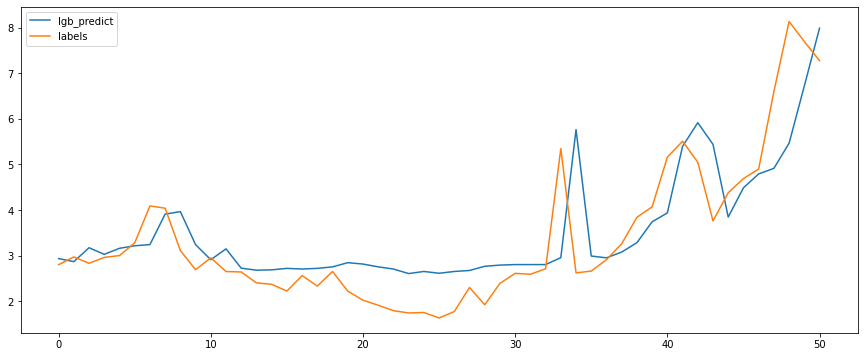

In [41]:
plt.figure(figsize=(15,6))
plt.plot(np.array(lgb_predict), label='lgb_predict')
# plt.plot(np.array(lr_predict), label='lr_predict')
plt.plot(np.array(Y_test), label='labels')
plt.legend()

In [27]:
# cal metrics: MAPE, ME, MAE, MPE, RMSE, corr and minmax.
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of lightgbm:')
accuracy_prod = forecast_accuracy(lgb_predict, Y_test)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print('-----------------')


print('Forecast Accuracy of linear_regression:')
accuracy_prod = forecast_accuracy(lr_predict, Y_test)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print('-----------------')

Forecast Accuracy of lightgbm:
mape :  0.2084
me :  0.1559
mae :  0.633
mpe :  0.1224
rmse :  0.9168
corr :  0.814
minmax :  0.1596
-----------------
Forecast Accuracy of linear_regression:
mape :  0.2021
me :  0.2542
mae :  0.609
mpe :  0.1213
rmse :  0.8555
corr :  0.8583
minmax :  0.1585
-----------------


/opt/anaconda3/envs/cryptoquant/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/cryptoquant/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  del sys.path[0]


##### 

**If we ignore the natural gas price's impact** (后面的可以忽略掉)

In [ ]:
feature_out = all_features.drop(['Natural_Gas_Price', 'Natural_Gas_Price_3m', 'Natural_Gas_Price_6m',
                                 'Natural_Gas_Price_dif1','Natural_Gas_Price_dif1_3m','Natural_Gas_Price_dif1_6m'])
feature_out

Index(['Crude_Oil_Price', 'Heating_Oil_Price', 'Drilling_activity',
       'Natural_Gas_Supply', 'Natural_Gas_Demand', 'Natural_Gas_Storage',
       'Natural_Gas_Import', 'Natural_Gas_Export', 'Crude_Oil_Price_dif1',
       'Crude_Oil_Price_dif1_3m', 'Crude_Oil_Price_dif1_6m',
       'Crude_Oil_Price_3m', 'Crude_Oil_Price_6m', 'Heating_Oil_Price_dif1',
       'Heating_Oil_Price_dif1_3m', 'Heating_Oil_Price_dif1_6m',
       'Heating_Oil_Price_3m', 'Heating_Oil_Price_6m',
       'Drilling_activity_dif1', 'Drilling_activity_dif1_3m',
       'Drilling_activity_dif1_6m', 'Drilling_activity_3m',
       'Drilling_activity_6m', 'Natural_Gas_Supply_dif1',
       'Natural_Gas_Supply_dif1_3m', 'Natural_Gas_Supply_dif1_6m',
       'Natural_Gas_Supply_3m', 'Natural_Gas_Supply_6m',
       'Natural_Gas_Demand_dif1', 'Natural_Gas_Demand_dif1_3m',
       'Natural_Gas_Demand_dif1_6m', 'Natural_Gas_Demand_3m',
       'Natural_Gas_Demand_6m', 'Natural_Gas_Storage_dif1',
       'Natural_Gas_Storage_dif1_3m

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_out], df['label'], test_size=0.2, shuffle=False)

lgb_train = lgb.Dataset(X_train,Y_train)
lgb_eval = lgb.Dataset(X_test,Y_test,reference=lgb_train)

params = {'task':'train',
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':{'l2','mse'},
    'num_leaves':31,
    'learning_rate':0.05,
    'feature_fraction':0.9,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbose':0}


#使用选择的参数进行训练
gbm = lgb.train(params,lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    early_stopping_rounds=5, 
    verbose_eval=False)  
#verbose_eval=False这个参数是控制每次训练不输出迭代效果参数

#下面进行预测
lgb_predit = gbm.predict(X_test,num_iteration=gbm.best_iteration) 
#输出均方根误差
print(mean_squared_error(Y_test,lgb_predit) ** 0.5)     

### 保存模型特征重要性，方便后面特征选择
importance_df = pd.DataFrame(X_train.columns.tolist(), columns=['feature'])
importance_df['importance']=list(gbm.feature_importance())                
# 特征分数
importance_df = importance_df.sort_values(by='importance',ascending=False)  
importance_df   

1.1552282390640443


,feature,importance
2,Drilling_activity,30
20,Drilling_activity_dif1_6m,23
0,Crude_Oil_Price,21
26,Natural_Gas_Supply_3m,20
5,Natural_Gas_Storage,17
42,Natural_Gas_Import_6m,15
18,Drilling_activity_dif1,14
11,Crude_Oil_Price_3m,12
19,Drilling_activity_dif1_3m,12
15,Heating_Oil_Price_dif1_6m,11


In [ ]:
# cal metrics: MAPE, ME, MAE, MPE, RMSE, corr and minmax.
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy:')
accuracy_prod = forecast_accuracy(df_results[variable + '_forecast'].values, df_test[variable])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
print('-----------------')

In [ ]:
Y_pred = gbm.predict(X_test)
x=Y_pred-np.mean(Y_pred)
y=Y_test-np.mean(Y_test)
#皮尔逊相关系数
corr=np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
print('corr:',corr)

corr: 0.801336980735225


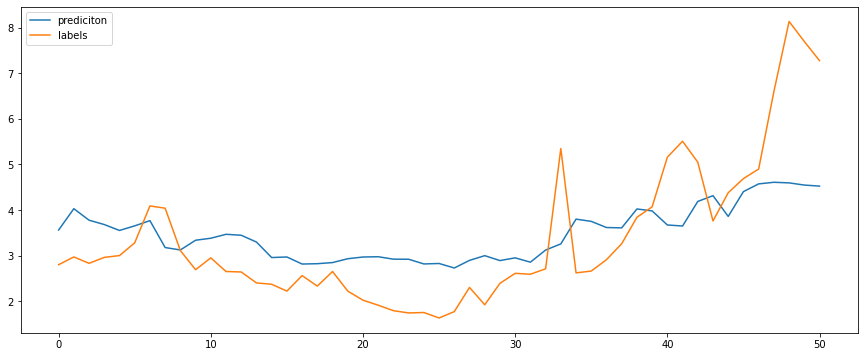

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.array(Y_pred), label='prediciton')
plt.plot(np.array(Y_test), label='labels')
plt.legend()

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(df)
# df1 = scaler.transform(df)

In [ ]:
mean = np.array(df.iloc[: int(len(df)*0.7)].describe().loc['mean'])
std = np.array(df.iloc[: int(len(df)*0.7)].describe().loc['std'])

In [ ]:

class preprocessing():
    def __init__(self):
        pass

    def create_dataset(self, data, sequence_length):
        total_len = len(data)
        X = []
        Y = []
        for i in range(total_len - sequence_length):
            X.append(np.array(data.iloc[i:(i + sequence_length), :].values, dtype=np.double))
            Y.append(np.array(data.iloc[(i + sequence_length), 0], dtype=np.double))
            # Y.append(np.array(data.iloc[(i + sequence_length), 0]/data.iloc[(i + sequence_length)-1, 0] - 1, dtype=np.double))

        X = np.array(X)
        Y = np.array(Y)

        trainx, trainy = X[: int(0.7 * total_len)], Y[: int(0.7 * total_len)]
        valx, valy = X[int(0.7 * total_len): int(0.85 * total_len)], Y[int(0.7 * total_len): int(0.85 * total_len)]
        testx, testy = X[int(0.85 * total_len):], Y[int(0.85 * total_len):]
        
        mean_fory = np.mean(trainy)
        std_fory = np.std(trainy)
        
        train_loader = DataLoader(dataset=Mydataset(trainx, trainy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=True)
        val_loader = DataLoader(dataset=Mydataset(valx, valy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=False)
        test_loader = DataLoader(dataset=Mydataset(testx, testy, normalize=[mean,std,mean_fory, std_fory]), batch_size=2, shuffle=False)

        # train_loader = DataLoader(dataset=Mydataset(trainx, trainy), batch_size=1, shuffle=False)
        # val_loader = DataLoader(dataset=Mydataset(valx, valy), batch_size=1, shuffle=False)
        # test_loader = DataLoader(dataset=Mydataset(testx, testy), batch_size=1, shuffle=False)

        return train_loader, val_loader, test_loader, mean_fory, std_fory


class Mydataset(Dataset):

    def __init__(self, xx, yy, normalize=None):
        self.x = torch.from_numpy(xx)
        self.y = torch.from_numpy(yy)
        self.normalize = normalize

    def __getitem__(self, index):
        x1 = self.x[index]
        y1 = self.y[index]
        # print(x1.shape)
        
        if self.normalize != None:
            x1 = (x1 - torch.from_numpy(self.normalize[0]))/torch.from_numpy(self.normalize[1])
            y1 = (y1 - torch.from_numpy(np.array(self.normalize[2])))/torch.from_numpy(np.array(self.normalize[3]))

        return x1, y1

    def __len__(self):
        return len(self.x)


In [ ]:
da = preprocessing()
train_loader, val_loader, test_loader, mean_fory, std_fory = da.create_dataset(df, sequence_length=8)

In [ ]:
class lstm(nn.Module):

    def __init__(self, input_size=9, hidden_size=32, output_size=1):
        super(lstm, self).__init__()
        # lstm input #batch, seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)  
        a, b, c = hidden.shape
        out = self.linear(hidden.reshape(a * b, c))
        
        return out

In [ ]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(9, 256, 6)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        
        self.lstm = torch.nn.LSTM(input_size=256, hidden_size=512, batch_first=True)

        self.fc1 = torch.nn.Linear(512,1)
        
    def forward(self,x):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)

        # z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        # z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        # positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        # input_embedding = z_embedding+positional_embeddings
        # input_embedding returns shape (Batch size,sequence len, embedding size) -> need (sequence len, Batch size, embedding_size)

        # input_x: (Batch size, sequence len, embedding size)
        x = x.permute(0, 2, 1)

        input_embedding = self.input_embedding(x).permute(2,0,1)

        transformer_embedding = self.transformer_encoder(input_embedding)

        out, (hidden, cell) = self.lstm(transformer_embedding.permute(1,0,2))

        a, b, c = hidden.shape

        out = self.fc1(hidden.reshape(a * b, c))
        
        return out

In [ ]:
model = lstm()
summary(model, (8, 12, 9))

Layer (type:depth-idx)                   Output Shape              Param #
lstm                                     [8, 1]                    --
├─LSTM: 1-1                              [8, 12, 32]               5,504
├─Linear: 1-2                            [8, 1]                    33
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05

In [ ]:
tsmodel = TransformerTimeSeries()
summary(tsmodel, (8, 100, 9))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerTimeSeries                         [8, 1]                    1,446,144
├─context_embedding: 1-1                      [8, 256, 100]             --
│    └─CausalConv1d: 2-1                      [8, 256, 100]             14,080
├─TransformerEncoder: 1-2                     [100, 8, 256]             --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [100, 8, 256]             1,315,072
│    │    └─TransformerEncoderLayer: 3-2      [100, 8, 256]             1,315,072
│    │    └─TransformerEncoderLayer: 3-3      [100, 8, 256]             1,315,072
├─LSTM: 1-3                                   [8, 100, 512]             1,576,960
├─Linear: 1-4                                 [8, 1]                    513
Total params: 6,982,913
Trainable params: 6,982,913
Non-trainable params: 0
Total mult-adds (G): 1.59
Input size (MB): 0.03
Forwar

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

In [ ]:
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
best_val_loss = np.inf
best_val_epoch = 0

for i in range(epochs):
    train_loss = []
    for idx, (data, label) in enumerate(train_loader):
        pred = model(data.float())
        label = label.float()
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)


    model.eval()
    with torch.no_grad():
        val_loss = []
        for idx, (data, label) in enumerate(val_loader):   
            pred = model(data.float())
            label = label.float()
            loss = criterion(pred, label)
            val_loss.append(loss.item())
        val_loss = np.mean(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'lstm_gas.pt')
                # torch.save(model, './best_val_model_pytorch')
            best_val_loss = val_loss
            best_val_epoch = i
            print('model saved')

    train_losses[i] = train_loss
    val_losses[i] = val_loss
    # print(i)
    # print('train_loss: ' + str(train_loss) + 'val_loss: '+ str(val_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model saved
model saved
model saved
model saved


In [ ]:
print(best_val_loss)
print(best_val_epoch)

0.08585290245246142
15


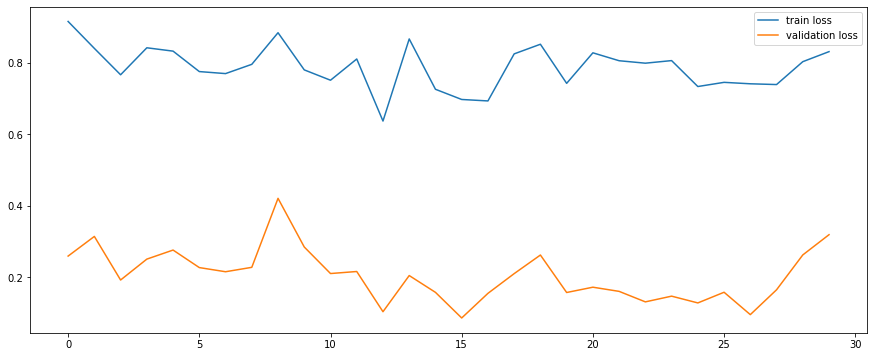

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [ ]:
model = lstm()
model.load_state_dict(torch.load('lstm_gas.pt'))
model.eval()
with torch.no_grad():
    preds = []
    labels = []
    for idx, (data, label) in enumerate(test_loader):   
        pred = np.array(model(data.float()))
        label = np.array(label.float())
        for i in range(len(pred)):
            preds.append(pred[i]*std_fory + mean_fory)
            labels.append(label[i]*std_fory + mean_fory)

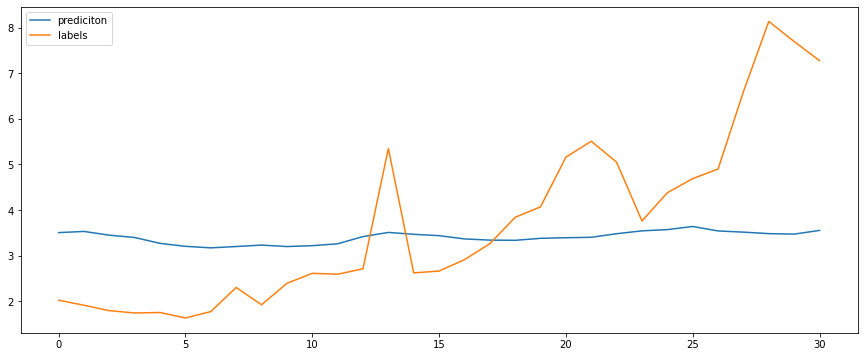

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(np.array(preds), label='prediciton')
plt.plot(np.array(labels), label='labels')
plt.legend()